Importing

In [26]:
import torch
from torch.optim import Adamax
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from scipy import integrate # numerical integration tool for ode's

Physical System to Model: Spring, Mass, and Damper System

$ F(t) -c \frac{d\mathbf{x}}{d t}(t) - kx(t) = m\frac{d\mathbf{x^2}}{d t}(t)$

$\frac{d\mathbf{x^2}}{d t}(t) = ( F(t) -c \frac{d\mathbf{x}}{d t}(t) - kx(t) ) /m$

Text(0.5, 1.0, 'Numerical Solution to Spring, Mass, and Damper system')

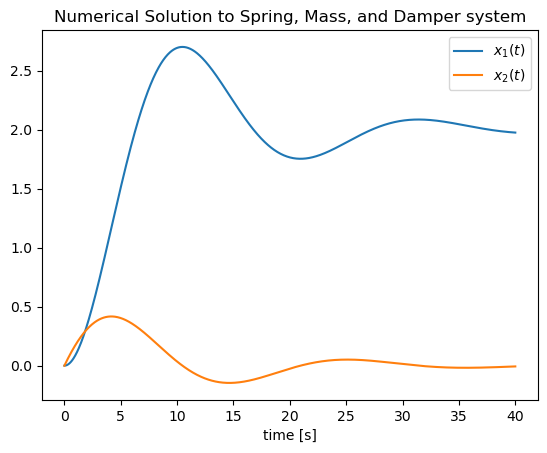

In [34]:
# Physical Parameters, C = damping constant, k =  stiffness of spring, m = mass.
p = dict(c=4, k=2, m=20, F=4)

def f(x,t,p):
    x1, x2 = x[0], x[1]
    dx1 = x2
    dx2 = (p['F'] - p['c']*x2 - p['k']*x1) / p['m']
    return([dx1,dx2])

#Function to solve the physical system using numerical integration tool
def run_oscil(x0,T,p):
    t = np.linspace(0, T, 1000)
    dxdt = lambda x,t : f(x, t, p)
    x_t = integrate.odeint(dxdt, x0, t)
    return(t,x_t)

#Plotting neumerical solution

#initial conditions
x0 = [0,0]
#plot to time T
T = 50

t_plot, x_plot = run_oscil(x0,40,p)
plt.plot(t_plot,x_plot)
plt.xlabel('time [s]')
#x_1 is position, x_2 is velocity
plt.legend(['$x_1(t)$','$x_2(t)$'])
plt.title("Numerical Solution to Spring, Mass, and Damper system")


The equation that models the Spring, Mass, and Damper System is the following:
$ F(t) = m\frac{d\mathbf{x^2}}{d t}(t) + c \frac{d\mathbf{x}}{d t}(t) + kx(t)$

The following parameters are needed to fully define the system:
1. Sum of Forces (F)
2. Mass (m)
3. Spring Constant (c)
4. Spring Stiffness (k)
5. Time (t)
6. Initial Conditions (x0)

These parameters can be used to determine the position (x) at current time (t).

Creating vectors for all parameters to be modelled

In [35]:
# number of vectors
num = 100
# number of parameters
params = 7
# x values from uniform random distribution between 0 and 10
X_train = np.random.rand(num,params)*40

X_train = torch.from_numpy(X_train).float()


Defining the Model, Loss and Optimizer

In [4]:
# len i/o nodes, i_len nodes per layer and ELU activation fn
i_len = 30

model = nn.Sequential(
    nn.Linear(params, i_len),
    nn.ELU(),
    nn.Linear(i_len, i_len),
    nn.ELU(),
    nn.Linear(i_len, i_len),
    nn.ELU(),
    nn.Linear(i_len, params)
    )

# choose optimizer
optim = Adamax(model.parameters())

Creating a custom loss function using the following:

$ F(t) - m\frac{d\mathbf{x^2}}{d t}(t) - c \frac{d\mathbf{x}}{d t}(t) - kx(t)$ = 0


In [ ]:
class CustomLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean'):
        super(CustomLoss, self).__init__()
        # Define parameters you need for your loss function if needed.

    def forward(self, pred, inputs):
        # pred: model's output
        # inputs: vector with cols 1:F, 2:m, 3:c, 4:k, 5:t, 6:x(0), 7:x'(0)

        # Ensure requires_grad = true in input tensor!
        # Obtaining parameters to compute loss.
        x = pred
        x_1 = torch.autograd.grad(outputs=pred, inputs=inputs[:,4], grad_outputs=torch.ones_like(pred), retain_graph=True)[0]
        x_2 = torch.autograd.grad(outputs=pred, inputs=inputs[:,4], grad_outputs=torch.ones_like(pred), retain_graph=True)[0]
        f = input[:,0]
        m = input[:,1]
        c = input[:,2]
        k = input[:,3]
        
        # Calculate the loss
        loss = torch.square(f - m*x_2 - c*x_1 - k*x)
        loss = torch.sum(loss)
        
        return loss

Train...